In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import warnings

import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table, Column, join
from astropy.wcs import WCS
from astropy.modeling import models, fitting

from specutils import Spectrum1D
from specutils import SpectralRegion
from specutils.fitting import fit_generic_continuum
from specutils.fitting import fit_lines
from specutils.analysis import equivalent_width


In [2]:
# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.minor.size'] = 5

# Generic Spectra

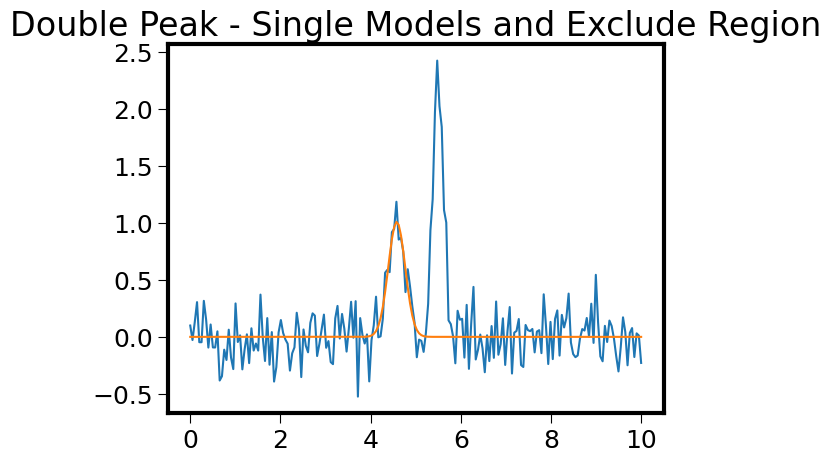

In [3]:
# Create a simple spectrum with a Gaussian.

np.random.seed(42)

g1 = models.Gaussian1D(1, 4.6, 0.2)

g2 = models.Gaussian1D(2.5, 5.5, 0.1)

x = np.linspace(0, 10, 200)

y = g1(x) + g2(x) + np.random.normal(0., 0.2, x.shape)

# Create the spectrum to fit

spectrum = Spectrum1D(flux=y*u.Jy, spectral_axis=x*u.um)

# Fit each peak

gl_init = models.Gaussian1D(amplitude=1.*u.Jy, mean=4.8*u.um, stddev=0.2*u.um)

gl_fit = fit_lines(spectrum, gl_init, exclude_regions=[SpectralRegion(5.2*u.um, 5.8*u.um)])

yl_fit = gl_fit(x*u.um)

fig, ax = plt.subplots()  

ax.plot(x, y)  

ax.plot(x, yl_fit)  

ax.set_title("Double Peak - Single Models and Exclude Region")  

plt.show() 

In [4]:
# Reduced data in txt files
data_path = "A:/Documents/Grad_School/Research/IGRINS_Merged/"
# File path for figures to live in
fig_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/standards_spectra/"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path+"merged_standards/m*.txt")

# NIR Lines in micron
nir_dict = {
    "Fe-2.084": 2.084,
    "Si-2.092"	:	2.092,
    "Mg-2.106"	:	2.106,
    "Al-2.11"	:	2.11,
    "Ca-2.2035"	:	2.2035,
    "Fe-2.2037"	:	2.2037,
    "Sc-2.2052"	:	2.2052,
    "Na-2.2052"	:	2.2052,
    "Si-2.2063"	:	2.2063,
    "Sc-2.2065"	:	2.2065,
    "Si-2.2073"	:	2.2073,
    "Fe-2.2079"	:	2.2079,
    "Na-2.2083"	:	2.2083,
    "Ca-2.2113"	:	2.2113,
    "Br-Gamma"  :   2.1655,
    "Ti-2.2218"	:	2.2218,
    "Ti-2.224"	:	2.224,
    "Fe-2.226"	:	2.226,
    "Ti-2.228"	:	2.228,
    "Ti-2.232"	:	2.232,
    "Ca-2.26573"	:	2.26573,
    "Fe-2.2742"	:	2.2742,
    "Mg-2.281"	:	2.281,
    "Ca-2.2825"	:	2.2825,
    "Fe-2.284"	:	2.284,
    "Ti-2.29"	:	2.29,
    "Ti-2.297"	:	2.297,
    "CO(2-0)-2.29353" :	2.29353,
    "CO(2-0)-2.32265"	:	2.32265,
    "CO(2-0)-2.34327" :	2.34327,
    "CO(2-0)-2.34531" :	2.34531,
    "CO(2-0)-2.3495" 	:	2.3495,
    "CO(2-0)-2.35167"	:	2.35167,
    "CO(2-0)-2.35246" :	2.35246,
    "CO(2-0)-2.38295" :	2.38295,
}

# Strings of the Nir lines
lines_str = list(nir_dict.keys())

# Wavelength values for each NIR line
lines_wav = list(nir_dict.values())

In [5]:
# Pandas Column IDs
igrins_cols = ['Wavelength', 'Flux', 'SNR','zero']

# Apply median filtering to the flux column
window_size = 1001  # Size of the median filter window

# Anon 1
anon1_df = pd.read_csv(merged_standard_files[0], delimiter='\s+', comment='#', names = igrins_cols)
# SNR column is an object for some reason, change to float
anon1_df['SNR'] = anon1_df['SNR'].astype(float)

# No negative flux and require SNR > 5
anon1_df = anon1_df[(anon1_df['Flux'] > 0) & (anon1_df['SNR'] > 5) & (anon1_df['SNR'] < 10000)] 

# Wavelength + Flux Arrays
anon1_wavlen = anon1_df['Wavelength']
anon1_flux = anon1_df['Flux']

# Try to do some continuum fitting

In [6]:
# Convert wavelength from microns to Angstroms
anon1_wavlen_angstrom = anon1_wavlen * 1e4  # 1 micron = 1e4 Angstrom

spectrum = Spectrum1D(spectral_axis=anon1_wavlen.values*u.micron, flux=anon1_flux.values * u.count)

spectrum

<Spectrum1D(flux=<Quantity [ 160973. , 1326200. , 1280167.9, ...,  584677. ,  524094. ,
            522688. ] ct>, spectral_axis=<SpectralAxis [1.9005899, 1.90061  , 1.90826  , ..., 2.4823599, 2.4823699, 2.4823799] micron>)>

In [8]:
fit_generic_continuum(spectrum,exclude_regions=[SpectralRegion(2.0*u.micron)])

TypeError: 'Quantity' object with a scalar value is not iterable

In [ ]:
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    g1_fit = fit_generic_continuum(spectrum)

TypeError: 'int' object is not callable

In [ ]:
continuum_fitted = g1_fit

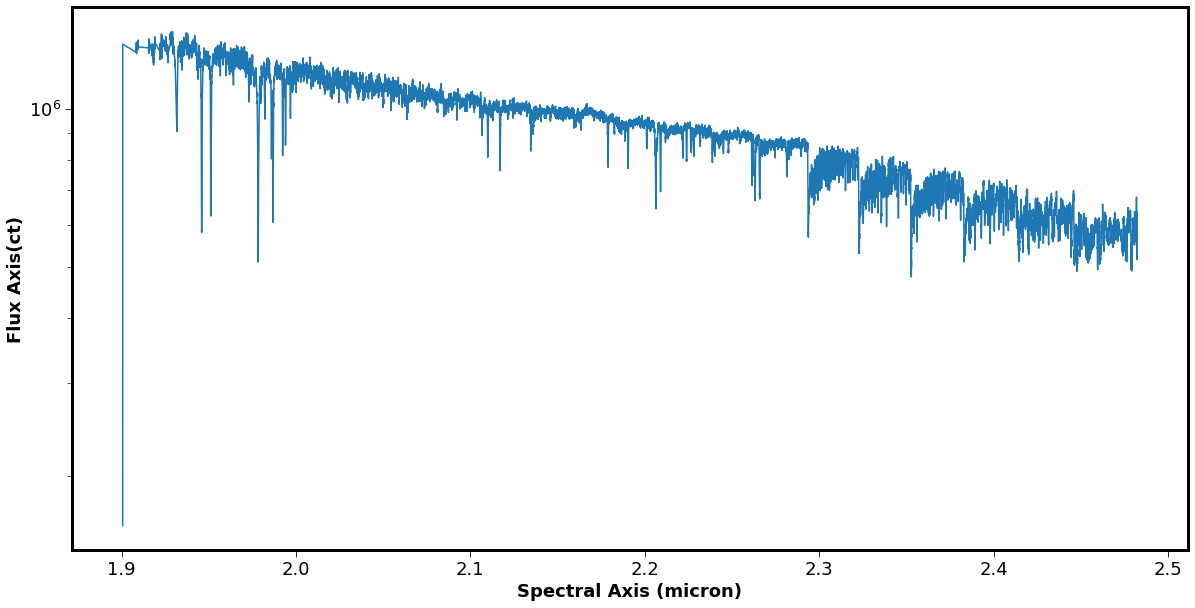

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))

plt.plot(spectrum.spectral_axis, spectrum.flux)
# plt.plot(spectrum.spectral_axis,continuum_fitted)

# plt.xlim(2,anon1_wavlen.values[-1])
# ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('Spectral Axis ({})'.format(spectrum.spectral_axis.unit)) 

plt.ylabel('Flux Axis({})'.format(spectrum.flux.unit)) 
plt.show()